In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from sklearn.preprocessing import TargetEncoder
from stop_words import get_stop_words
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import pandas as pd

from utils.data_utils import (
    preprocessing,
    custom_train_test_split,
    generate_cm,
    plot_cm,
    plot_hist,
)

clean_df = pd.read_csv("./data/cleaned_data.csv", sep=";")

sns.set_palette("rocket")
sns.set_theme()

with pd.option_context("display.float_format", "{:.1f}".format):
    print(
        clean_df["price_pln"].describe(
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]
        )
    )

count      23752
unique      4900
top       39 900
freq         293
Name: price_pln, dtype: object


Min number of samples in bin:  138
Max number of samples in bin:  2878


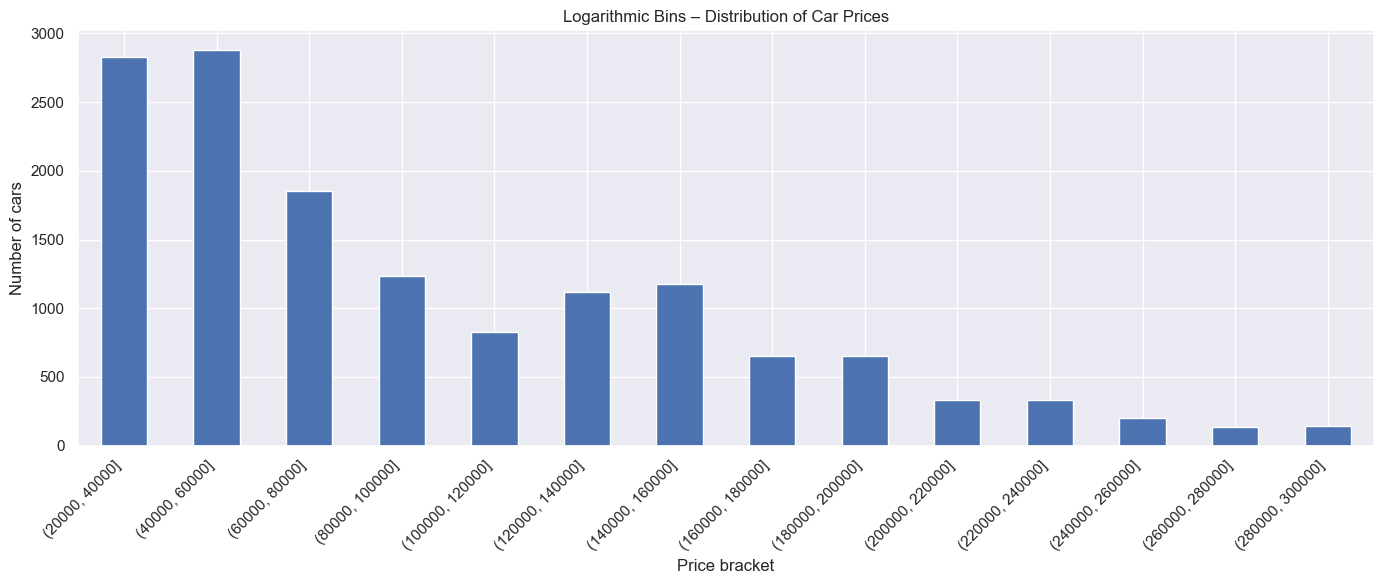

Min number of samples in bin:  376
Max number of samples in bin:  1539


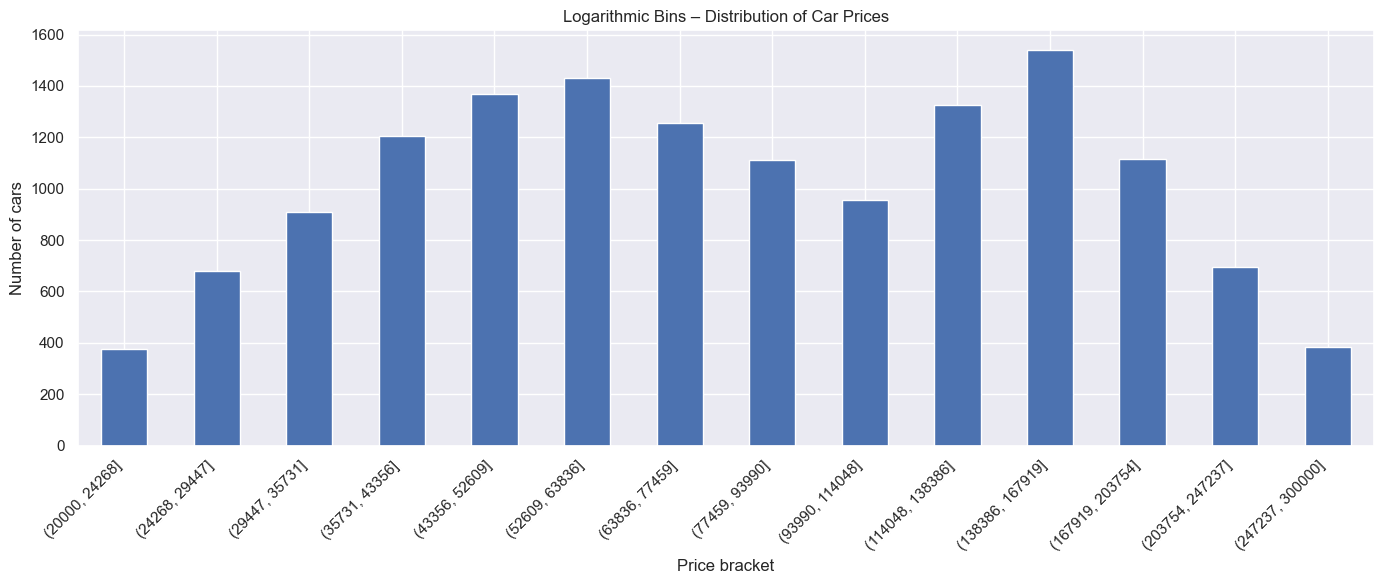

Number of classes: 14


In [63]:
df, lin_bins, log_bins = preprocessing(
    clean_df, step=20_000, min_price=20_000, max_price=300_000
)


plot_hist(
    df,
    bins=lin_bins,
    title="Linear Bins – Distribution of Car Prices",
    xlabel="Number of cars",
    ylabel="Linear Bins",
)


plot_hist(
    df,
    bins=log_bins,
    title="Logarithmic Bins – Distribution of Car Prices",
    xlabel="Number of cars",
    ylabel="Logarithmic Bins",
)


X_train, X_test, y_train, y_test = custom_train_test_split(
    df, log_bins, test_size=0.2, random_state=42, description_only=False
)


In [64]:
pl_stopwords = get_stop_words("pl")

# Models for 20k step -- 14 classes

In [101]:
def train_rfecvs(X_train, y_train):
    cat_feats = ["model", "condition", "fuel", "brand", "body_type", "accident_free"]
    num_feats = ["year", "capacity", "power", "mileage", "seats"]

    text_col = "description"

    rfecv_preprocess = ColumnTransformer(
        [
            ("num", "passthrough", num_feats),
            ("cat", TargetEncoder(), cat_feats),
        ],
        remainder="drop",
    )

    rfecv_no_desc_model = Pipeline(
        [
            ("prep", rfecv_preprocess),
            (
                "rfecv",
                RFECV(
                    estimator=RandomForestClassifier(
                        n_estimators=250, n_jobs=-1, verbose=1
                    ),
                    cv=3,
                    step=1,
                    verbose=1,
                    scoring="accuracy",
                    n_jobs=-1,
                ),
            ),
        ]
    )

    rfecv_no_desc_model.fit(X_train, y_train)

    mask = rfecv_no_desc_model.named_steps["rfecv"].support_

    selected_num_cols = [
        col
        for col, keep in zip(num_feats + cat_feats, mask)
        if keep and col in num_feats
    ]
    selected_cat_cols = [
        col
        for col, keep in zip(num_feats + cat_feats, mask)
        if keep and col in cat_feats
    ]

    preprocess_tfidf = ColumnTransformer(
        [
            (
                "text",
                TfidfVectorizer(max_features=5000, stop_words=pl_stopwords),
                text_col,
            ),
        ],
        remainder="drop",
    )

    rfecv_only_desc_model = Pipeline(
        [
            ("prep", preprocess_tfidf),
            ("clf", RandomForestClassifier(n_estimators=250, n_jobs=-1)),
        ]
    )

    rfecv_only_desc_model.fit(X_train, y_train)

    preprocess_tfidf_all_feats = ColumnTransformer(
        [
            ("num", "passthrough", selected_num_cols),
            ("cat", TargetEncoder(), selected_cat_cols),
            (
                "text",
                TfidfVectorizer(max_features=5000, stop_words=pl_stopwords),
                text_col,
            ),
        ],
        remainder="drop",
    )

    rfecv_tfidf_model = Pipeline(
        [
            ("prep", preprocess_tfidf_all_feats),
            ("clf", RandomForestClassifier(n_estimators=250, n_jobs=-1)),
        ]
    )

    rfecv_tfidf_model.fit(X_train, y_train)
    
    return {
        "no_desc": rfecv_no_desc_model,
        "only_desc": rfecv_only_desc_model,
        "with_desc": rfecv_tfidf_model,
        "selected_num_cols": selected_num_cols,
        "selected_cat_cols": selected_cat_cols,
    }

In [ ]:
models_20k = train_rfecvs(X_train, y_train)

## TFIDF Description

In [ ]:
def fmt_k_rounded(arr):
    return [f"{round(x / 1000)}k" for x in arr]


accuracy: 0.5104384133611691

report:
               precision    recall  f1-score   support

         0.0       0.62      0.25      0.35        81
         1.0       0.50      0.38      0.43       128
         2.0       0.32      0.37      0.34       155
         3.0       0.33      0.40      0.36       252
         4.0       0.38      0.44      0.40       288
         5.0       0.42      0.51      0.46       282
         6.0       0.43      0.46      0.44       238
         7.0       0.51      0.41      0.45       234
         8.0       0.63      0.50      0.55       202
         9.0       0.68      0.60      0.63       278
        10.0       0.63      0.72      0.67       301
        11.0       0.69      0.67      0.68       224
        12.0       0.77      0.63      0.69       138
        13.0       0.64      0.63      0.63        73

    accuracy                           0.51      2874
   macro avg       0.54      0.50      0.51      2874
weighted avg       0.53      0.51      0.

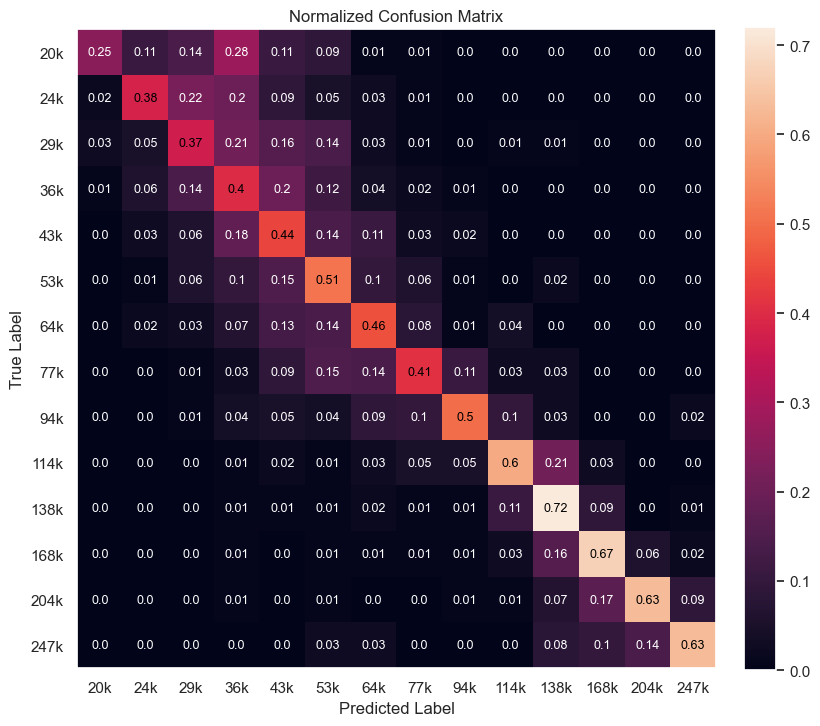

In [ ]:
y_pred = models_20k["only_desc"].predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)
labels = fmt_k_rounded(log_bins)[0:-1]

# plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(
    cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels
)


## RFECV + TFIDF Description

accuracy: 0.5379262352122477

report:
               precision    recall  f1-score   support

         0.0       0.69      0.27      0.39        81
         1.0       0.50      0.45      0.47       128
         2.0       0.45      0.45      0.45       155
         3.0       0.40      0.46      0.43       252
         4.0       0.47      0.49      0.48       288
         5.0       0.45      0.55      0.50       282
         6.0       0.39      0.50      0.44       238
         7.0       0.54      0.45      0.49       234
         8.0       0.64      0.51      0.57       202
         9.0       0.69      0.59      0.64       278
        10.0       0.63      0.73      0.68       301
        11.0       0.67      0.66      0.67       224
        12.0       0.74      0.59      0.66       138
        13.0       0.64      0.64      0.64        73

    accuracy                           0.54      2874
   macro avg       0.57      0.52      0.54      2874
weighted avg       0.55      0.54      0.

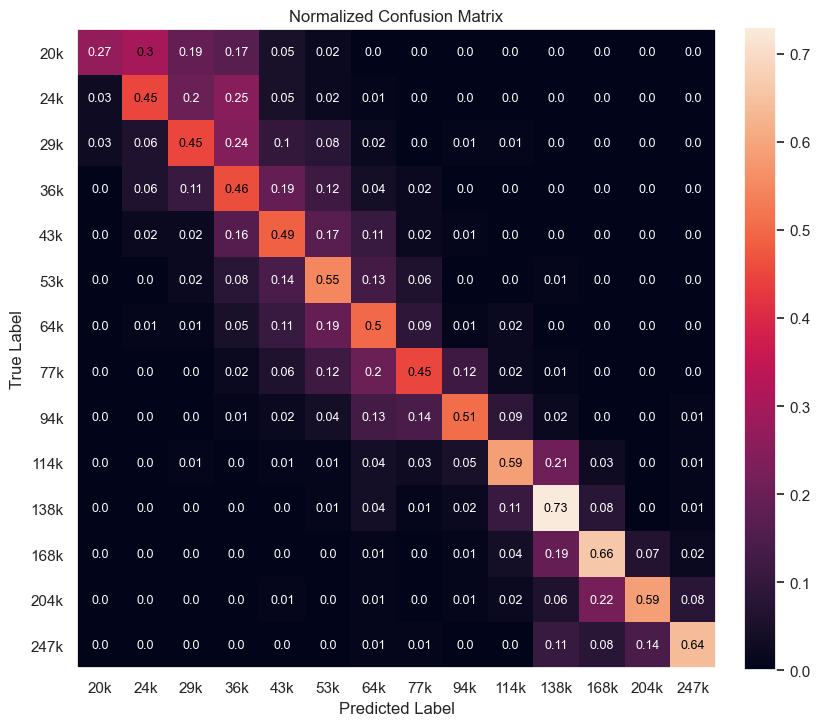

In [ ]:
y_pred = models_20k["with_desc"].predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)

# plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(
    cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels
)

## RFECV without description field

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished


accuracy: 0.5260960334029228

report:
               precision    recall  f1-score   support

         0.0       0.67      0.40      0.50        81
         1.0       0.53      0.60      0.56       128
         2.0       0.43      0.50      0.46       155
         3.0       0.46      0.44      0.45       252
         4.0       0.41      0.41      0.41       288
         5.0       0.46      0.49      0.47       282
         6.0       0.41      0.45      0.43       238
         7.0       0.52      0.51      0.51       234
         8.0       0.56      0.50      0.53       202
         9.0       0.66      0.64      0.65       278
        10.0       0.68      0.69      0.69       301
        11.0       0.57      0.57      0.57       224
        12.0       0.54      0.51      0.53       138
        13.0       0.60      0.67      0.64        73

    accuracy                           0.53      2874
   macro avg       0.54      0.53      0.53      2874
weighted avg       0.53      0.53      0.

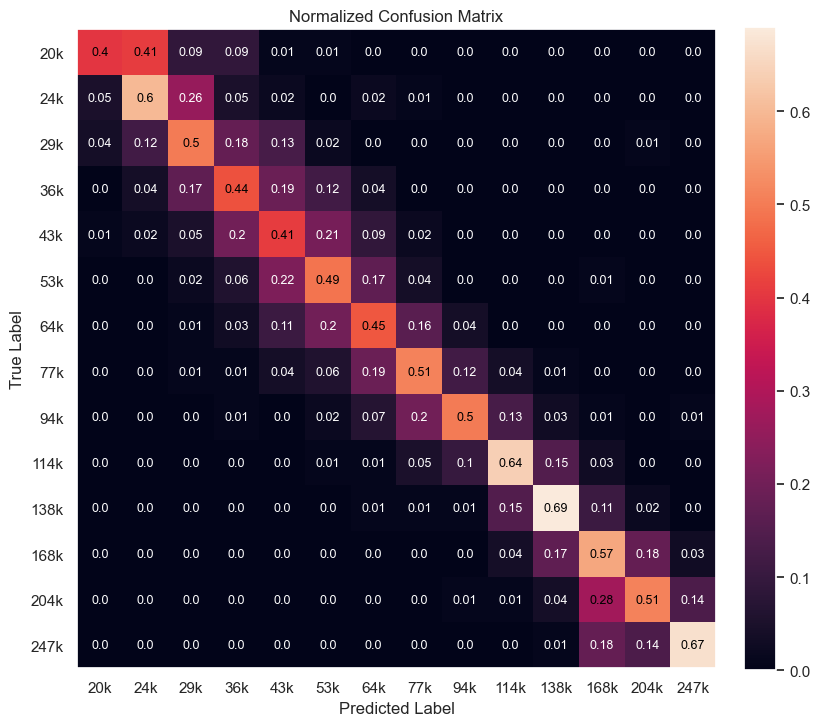

In [ ]:
y_pred = models_20k["no_desc"].predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)

# plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(
    cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels
)

# Models for 30k step -- 10 classes

In [104]:
df, lin_bins, log_bins = preprocessing(
    clean_df, step=30_000, min_price=20_000, max_price=300_000
)

X_train, X_test, y_train, y_test = custom_train_test_split(
    df, log_bins, test_size=0.2, random_state=42, description_only=False
)


models_30k = train_rfecvs(X_train, y_train)

Number of classes: 10


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Fitting estimator with 65 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.2s finished


Fitting estimator with 64 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.2s finished


Fitting estimator with 63 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 62 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 61 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 60 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 59 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 58 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 57 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 56 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 55 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.4s finished


Fitting estimator with 54 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 53 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.3s finished


Fitting estimator with 52 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.5s finished


Fitting estimator with 51 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.2s finished


Fitting estimator with 50 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.5s finished


Fitting estimator with 49 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 48 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.7s finished


Fitting estimator with 47 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    2.2s finished


Fitting estimator with 46 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.2s finished


Fitting estimator with 45 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 44 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 43 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 42 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 41 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 40 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 39 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.5s finished


Fitting estimator with 38 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 37 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 36 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 35 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 34 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.2s finished


Fitting estimator with 33 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 32 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 31 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 30 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 29 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 28 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 27 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 26 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 25 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 24 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 23 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 22 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 21 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.7s finished


Fitting estimator with 20 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 19 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 18 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 17 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 16 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 15 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 14 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 13 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.7s finished


Fitting estimator with 12 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.7s finished


Fitting estimator with 11 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.7s finished


Fitting estimator with 10 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.7s finished


Fitting estimator with 9 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.7s finished


Fitting estimator with 8 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.5s finished
/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words 

## TFIDF Description

accuracy: 0.559151009046625

report:
               precision    recall  f1-score   support

         0.0       0.75      0.33      0.46       141
         1.0       0.61      0.40      0.48       178
         2.0       0.39      0.60      0.47       365
         3.0       0.46      0.49      0.48       409
         4.0       0.46      0.52      0.49       331
         5.0       0.62      0.45      0.52       346
         6.0       0.65      0.51      0.57       308
         7.0       0.67      0.76      0.71       402
         8.0       0.75      0.72      0.74       267
         9.0       0.73      0.69      0.71       127

    accuracy                           0.56      2874
   macro avg       0.61      0.55      0.56      2874
weighted avg       0.58      0.56      0.56      2874



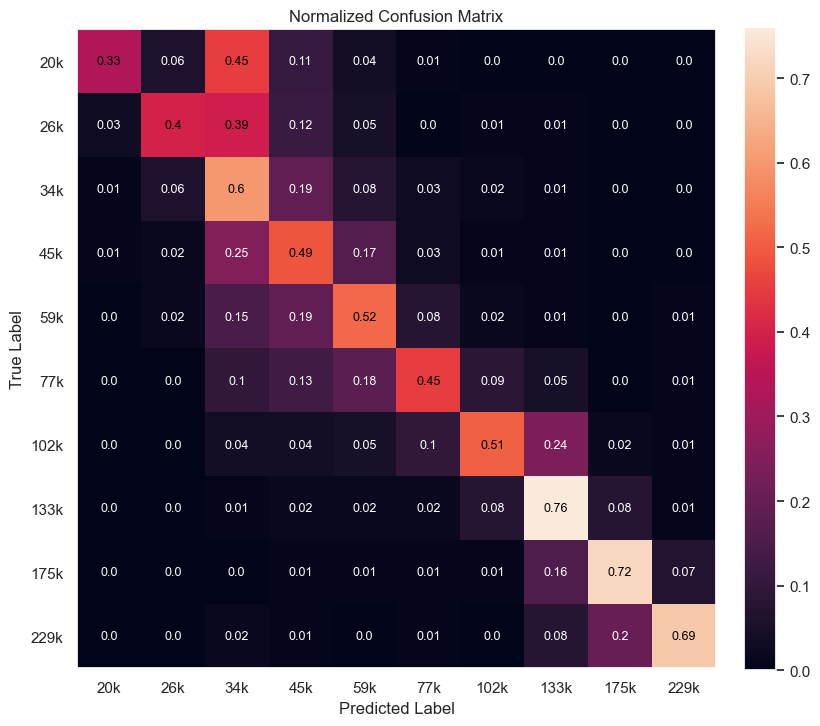

In [105]:
y_pred = models_30k["only_desc"].predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)
labels = fmt_k_rounded(log_bins)[0:-1]

# plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(
    cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels
)


## RFECV + TFIDF Description

accuracy: 0.5935977731384829

report:
               precision    recall  f1-score   support

         0.0       0.72      0.44      0.55       141
         1.0       0.61      0.39      0.48       178
         2.0       0.46      0.64      0.53       365
         3.0       0.51      0.51      0.51       409
         4.0       0.45      0.56      0.50       331
         5.0       0.64      0.52      0.57       346
         6.0       0.69      0.56      0.62       308
         7.0       0.71      0.78      0.75       402
         8.0       0.75      0.72      0.73       267
         9.0       0.75      0.68      0.71       127

    accuracy                           0.59      2874
   macro avg       0.63      0.58      0.60      2874
weighted avg       0.61      0.59      0.59      2874



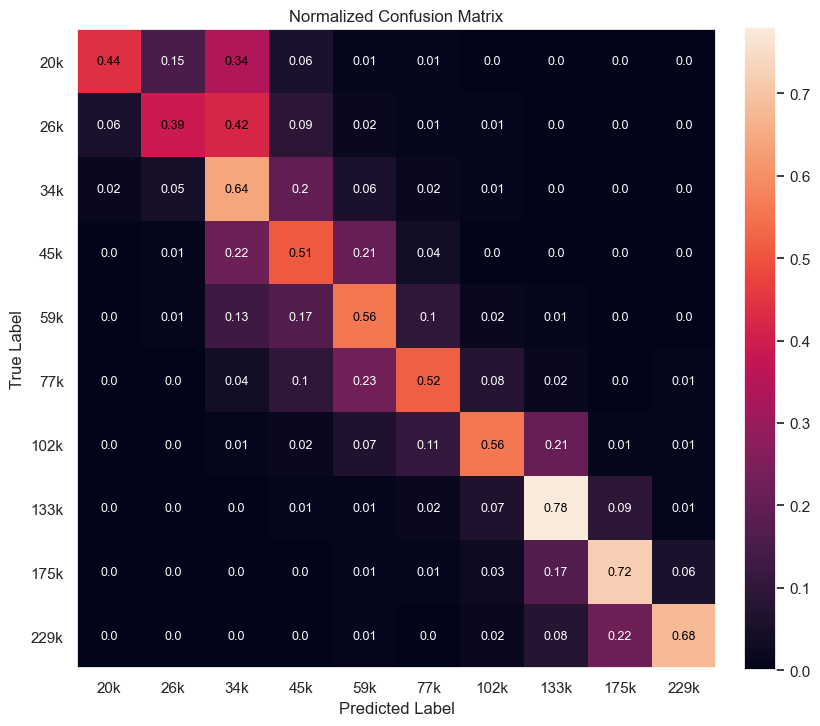

In [106]:
y_pred = models_30k["with_desc"].predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)

# plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(
    cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels
)

## RFECV without description field

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished


accuracy: 0.5904662491301322

report:
               precision    recall  f1-score   support

         0.0       0.73      0.60      0.66       141
         1.0       0.54      0.58      0.56       178
         2.0       0.56      0.55      0.55       365
         3.0       0.52      0.54      0.53       409
         4.0       0.46      0.53      0.49       331
         5.0       0.61      0.56      0.58       346
         6.0       0.62      0.58      0.60       308
         7.0       0.72      0.72      0.72       402
         8.0       0.65      0.63      0.64       267
         9.0       0.64      0.61      0.63       127

    accuracy                           0.59      2874
   macro avg       0.60      0.59      0.60      2874
weighted avg       0.60      0.59      0.59      2874



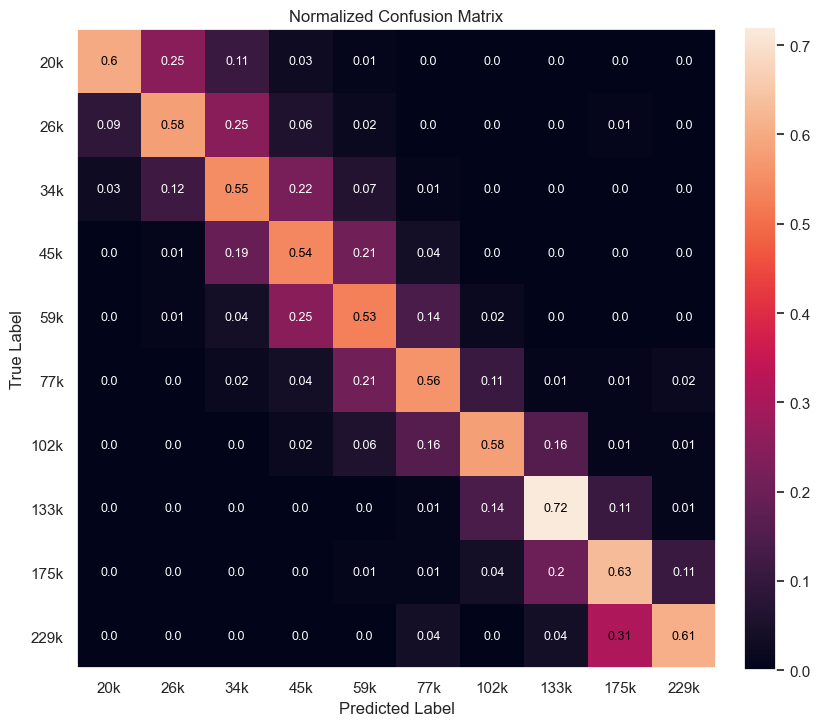

In [107]:
y_pred = models_30k["no_desc"].predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)

# plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(
    cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels
)

# Models for 40k step -- 7 classes

In [108]:
df, lin_bins, log_bins = preprocessing(
    clean_df, step=40_000, min_price=20_000, max_price=300_000
)

X_train, X_test, y_train, y_test = custom_train_test_split(
    df, log_bins, test_size=0.2, random_state=42, description_only=False
)


models_40k = train_rfecvs(X_train, y_train)

Number of classes: 7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

Fitting estimator with 47 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 46 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 45 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.4s finished


Fitting estimator with 44 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 43 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 42 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 41 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 40 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 39 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 38 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 37 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


Fitting estimator with 36 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 35 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 34 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 33 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 32 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 31 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 30 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 29 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 28 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 27 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 26 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.2s finished


Fitting estimator with 25 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.8s finished


Fitting estimator with 24 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.3s finished


Fitting estimator with 23 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.3s finished


Fitting estimator with 22 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 21 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 20 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    2.2s finished


Fitting estimator with 19 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.6s finished


Fitting estimator with 18 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 17 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 16 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished


Fitting estimator with 15 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.1s finished


Fitting estimator with 14 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


Fitting estimator with 13 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.6s finished


Fitting estimator with 12 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.3s finished


Fitting estimator with 11 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.7s finished


Fitting estimator with 10 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished
/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words 

## TFIDF Description

accuracy: 0.6297842727905358

report:
               precision    recall  f1-score   support

         0.0       0.79      0.34      0.47       209
         1.0       0.48      0.58      0.53       407
         2.0       0.52      0.66      0.58       570
         3.0       0.57      0.52      0.54       472
         4.0       0.76      0.62      0.68       480
         5.0       0.76      0.82      0.79       525
         6.0       0.85      0.72      0.78       211

    accuracy                           0.63      2874
   macro avg       0.68      0.61      0.63      2874
weighted avg       0.65      0.63      0.63      2874



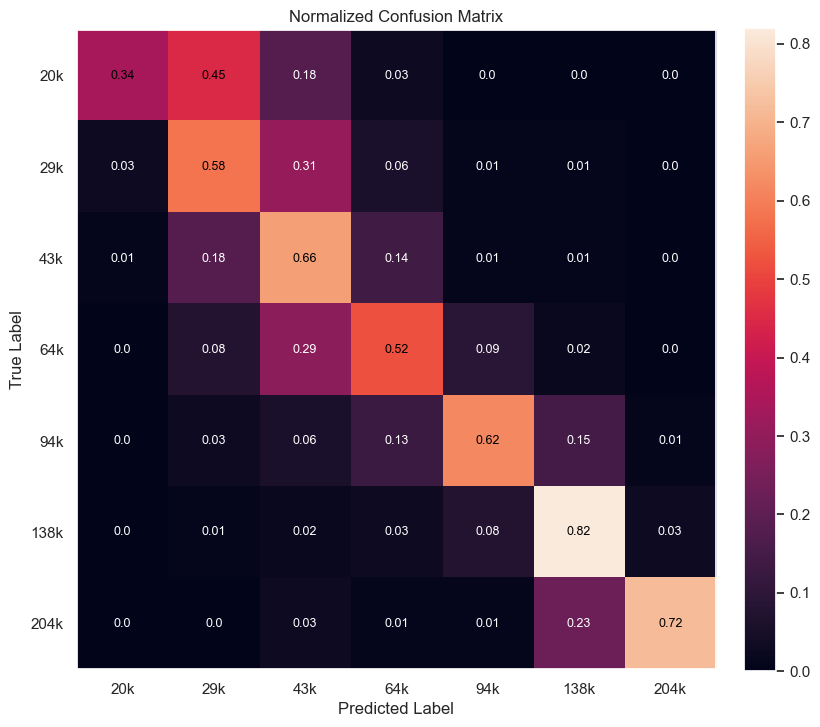

In [109]:
y_pred = models_40k["only_desc"].predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)
labels = fmt_k_rounded(log_bins)[0:-1]

# plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(
    cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels
)


## RFECV + TFIDF Description

accuracy: 0.6823242867084203

report:
               precision    recall  f1-score   support

         0.0       0.81      0.43      0.56       209
         1.0       0.58      0.65      0.61       407
         2.0       0.60      0.72      0.65       570
         3.0       0.61      0.59      0.60       472
         4.0       0.76      0.65      0.70       480
         5.0       0.78      0.86      0.82       525
         6.0       0.85      0.74      0.79       211

    accuracy                           0.68      2874
   macro avg       0.71      0.66      0.68      2874
weighted avg       0.69      0.68      0.68      2874



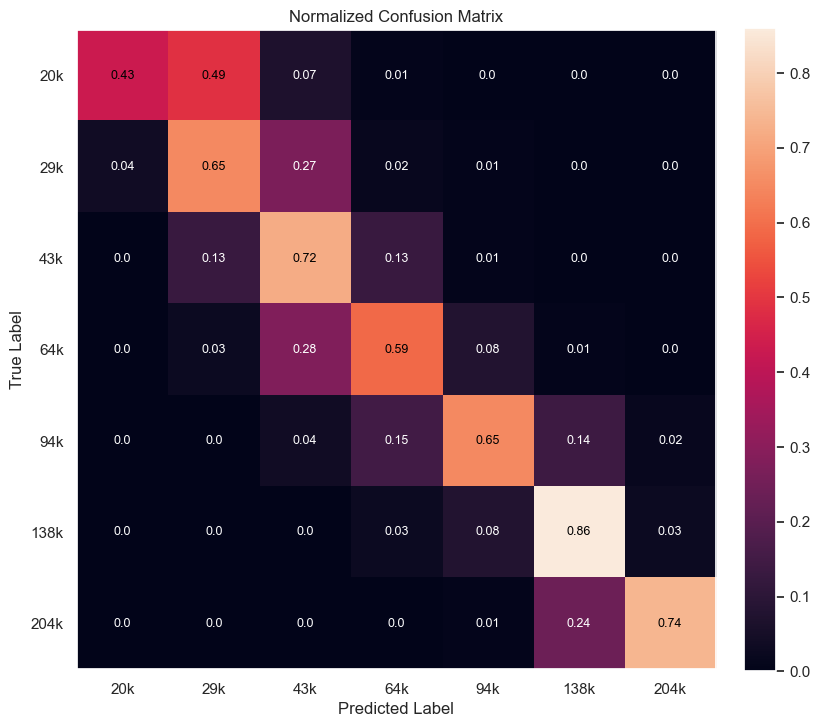

In [110]:
y_pred = models_40k["with_desc"].predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)

# plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(
    cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels
)

## RFECV without description field

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished


accuracy: 0.7122477383437718

report:
               precision    recall  f1-score   support

         0.0       0.78      0.66      0.72       209
         1.0       0.61      0.65      0.63       407
         2.0       0.67      0.71      0.69       570
         3.0       0.66      0.69      0.68       472
         4.0       0.77      0.71      0.74       480
         5.0       0.80      0.79      0.79       525
         6.0       0.76      0.75      0.76       211

    accuracy                           0.71      2874
   macro avg       0.72      0.71      0.71      2874
weighted avg       0.72      0.71      0.71      2874



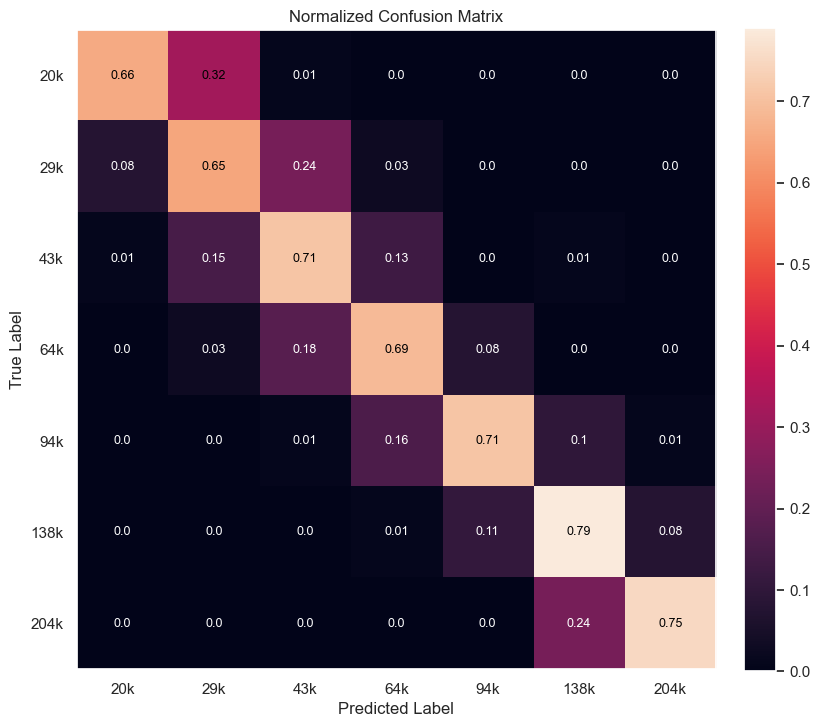

In [111]:
y_pred = models_40k["no_desc"].predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)

# plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(
    cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels
)